# Movies Recommendation Systems

This python notebook will get you started with building your own Recommendation engine. We cover the following:

1. Getting the data
2. Working with the dataset
3. Recommender libraries in R, Python
4. Data partitions (Train, Test)
5. Integrating a Popularity Recommender
6. Integrating a Collaborative Filtering Recommender
7. Integrating an Item-Similarity Recommender
8. Getting Top-K recommendations
9. Evaluation: RMSE
10. Evaluation: Confusion Matrix/Precision-Recall



# A. Data Set Overview
## A1. Loading Libraries

First we will import the necessary modules. Make sure to download graphlab from https://turi.com/ and make sure to register for a license. You can also download it from the command prompt on Mac or Linux using 'sudo pip install graphlab-create'. You will also need to install scikit-learn, pandas, matplotlib, and numpy.

In [2]:
%matplotlib inline
import matplotlib as mpl
mpl.use('TkAgg')
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import graphlab

## A2. Working with the Dataset

We will first load the dataset into the pandas data frame and inspect the data. Make sure you have the data downloaded and that the 'ml-100k' folder is in the same directory as this notebook.

We use the dataset(s) provided by [MovieLens](https://grouplens.org/datasets/movielens/). MovieLens has several datasets. You can choose any. For this tutorial, we will use the [100K dataset](https://grouplens.org/datasets/movielens/100k/) dataset. This dataset set consists of:
  
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.
* Simple demographic info for the users (age, gender, occupation, zip)
    
Download the "[*u.data*](http://files.grouplens.org/datasets/movielens/ml-100k/)" file. To view this file you can use Microsoft Excel, for example. It has the following tab-separated format: **user id** | **item id** | **rating** | **timestamp**. The timestamps are in Unix seconds since 1/1/1970 UTC, [EPOCH format](https://www.unixtimestamp.com/index.php).

In **Python**, you can convert the data to a [Pandas](https://pandas.pydata.org/) dataframe to organize the dataset. For plotting in Python, you can use [MatplotLib](https://matplotlib.org/).

In [3]:
col_names = ["user_id", "item_id", "rating", "timestamp"]
data = pd.read_table("ml-100k/u.data", names=col_names)
data = data.drop("timestamp", 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 3 columns):
user_id    100000 non-null int64
item_id    100000 non-null int64
rating     100000 non-null int64
dtypes: int64(3)
memory usage: 2.3 MB


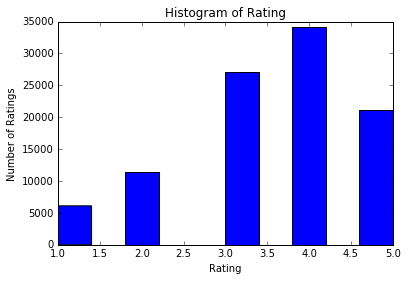

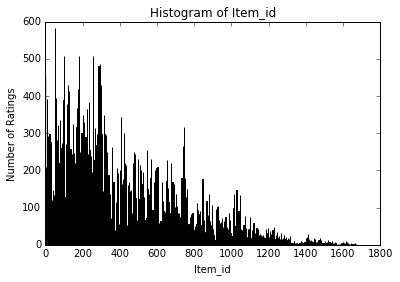

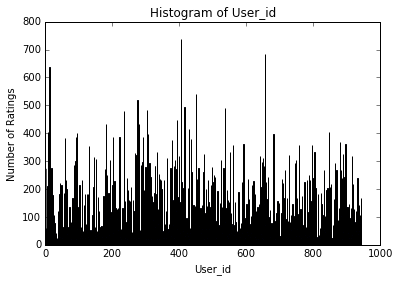

In [4]:
plt.hist(data["rating"], bins=10)
plt.xlabel('Rating')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Rating')
#plt.axis([0.5, 5.5, 0, 40000])
plt.show()
plt.hist(data["item_id"],bins=1800)
plt.xlabel('Item_id')
plt.ylabel('Number of Ratings')
plt.title('Histogram of Item_id')
#plt.axis([0.5, 5.5, 0, 40000])
plt.show()
plt.hist(data["user_id"],bins=1000)
plt.xlabel('User_id')
plt.ylabel('Number of Ratings')
plt.title('Histogram of User_id')
#plt.axis([0.5, 5.5, 0, 40000])
plt.show()

###### *<u>Comments:</u>*
1. a larger number of ratings with ratings of 3, 4, and 5 rather than rating of 1 and 2.
2. certain users (user_id) have number of rating as low as about 10, and as high as 700. A large amount of users has number of ratings from 50 to 200.
3. Movies with Item_id from 0-400 have more rating than the rest.

## A3. Calculating Sparsity

The sparsity of the dataset can be calculated as:

\begin{equation}
Sparsity = \frac{Number\:of\:Ratings\:in\:the\:Dataset}{(Number\:of\:Movies/Columns)*(Number\:of\:Users/Rows)}*100\%
\end{equation}

In [5]:
Number_Ratings = float(len(data))
Number_Movies = float(len(np.unique(data["item_id"])))
Number_Users = float(len(np.unique(data["user_id"])))
Sparsity = (Number_Ratings/(Number_Movies*Number_Users))*100.0
print"Sparsity of Dataset is", Sparsity, "Percent"

Sparsity of Dataset is 6.30466936422 Percent


###### *<u>Comments:</u>* If you want the data to be less sparse, for example, a good way to achieve that is to subset the data where you only select Users/Movies that have at least a certain number of observations in the dataset.

## A4. Subsetting the Data

Now we will subset the data. The criteria we are currently using is to not include a user if they have fewer than 50 ratings. This value can be changed in the RATINGS_CUTOFF variable.

In [6]:
users = data["user_id"]
ratings_count = {}
for user in users:
    if user in ratings_count:
        ratings_count[user] += 1
    else:
        ratings_count[user] = 1
RATINGS_CUTOFF = 50 # A user is not included if they have fewer than "RATINGS_CUTOFF" ratings
remove_users = []
for user,num_ratings in ratings_count.iteritems():
    if num_ratings < RATINGS_CUTOFF: 
        remove_users.append(user)
data = data.loc[~data['user_id'].isin(remove_users)]

## A5. Recalculate Sparsity

We will now recalculate the sparsity of the subsetted data.

In [7]:
Number_Ratings = float(len(data))
Number_Movies = float(len(np.unique(data["item_id"])))
Number_Users = float(len(np.unique(data["user_id"])))
Sparsity = (Number_Ratings/(Number_Movies*Number_Users))*100.0
print"Sparsity of Dataset is", Sparsity, "Percent"

Sparsity of Dataset is 9.26584192843 Percent




# B. Recommenders

If you want to build your own Recommenders from scratch, you can consult the vast amounts of academic literature available freely. There are also several self-help guides which can be useful, such as these:
* Collaborative Filtering with R;
* [How to build a Recommender System](https://blogs.gartner.com/martin-kihn/how-to-build-a-recommender-system-in-python/);

On the other hand, why build a recommender from scratch when there is a vast array of publicly available Recommenders (in all sorts of programming environments) ready for use? Some examples are:
* [RecommenderLab for R](https://cran.r-project.org/web/packages/recommenderlab/vignettes/recommenderlab.pdf);
* [Graphlab-Create](https://github.com/apple/turicreate/) for Python (has a free license for personal and academic use);
* [Apache Spark's Recommendation module](https://spark.apache.org/docs/1.4.0/api/python/pyspark.mllib.html#module-pyspark.mllib.recommendation);
* [Apache Mahout](https://mahout.apache.org/users/recommender/userbased-5-minutes.md);

For this tutorial, we will reference **Graphlab-Create**.

## B1. Preparing for Graphlab

Now we will turn the dataset into a graphlab SFrame so that we can use it's different recommendation models

In [9]:
sf = graphlab.SFrame(data) #Load dataset "data" with a graphlab SFrame

## B2. Creating a Train/Test Split

We now subset the data into Train, Validation, and Test sets to use for our different models

In [10]:
sf_train, sf_test = sf.random_split(.7) #split dataset "data": 70% for train & 30% for test

## B3. Popularity Recommender

Graphlab provides an easy to use popularity recommender. We create the model using the training data and test the RMSE on the test data.

In [11]:
#use training set (70% of dataset) to create the model
#the model computes the mean rating for each item and uses this to rank items for recommendations
popularity_recommender = graphlab.recommender.popularity_recommender.create(sf_train,target='rating')

#use test set (30% of dataset) to test the model 
#by evaluating prediction error for each user-item pair in the given data set
popularity_recommender.evaluate_rmse(sf_test,'rating')

Recsys training: model = popularity

Preparing data set.

Data has 62172 observations with 568 users and 1632 items.

Data prepared in: 0.094077s

62172 observations to process; with 1632 unique items.

{'rmse_by_item': Columns:
 	item_id	int
 	count	int
 	rmse	float
 
 Rows: 1476
 
 Data:
 +---------+-------+----------------+
 | item_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   75  | 1.16696698538  |
 |   1029  |   3   | 1.03386194601  |
 |   435   |   57  | 0.984195972784 |
 |   1517  |   3   | 1.29099444874  |
 |   537   |   7   | 1.27915631796  |
 |   526   |   40  | 0.893828439396 |
 |   232   |   28  | 0.929062872017 |
 |   310   |   19  | 0.821564830298 |
 |    49   |   29  |  1.0388903263  |
 |    13   |   55  | 1.06583878002  |
 +---------+-------+----------------+
 [1476 rows x 3 columns]
 Note: Only the head of the SFrame is printed.
 You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.,
 'rmse_by_user': Columns:
 	user_id	int
 	count	int
 	rmse	float
 
 Rows: 568
 
 Data:
 +---------+-------+----------------+
 | user_id | count |      rmse      |
 +---------+-------+----------------+
 |   118   |   19  | 1.

## B4. Collaborative Filtering

For collaborative filtering we will use Graphlabs Factorization Recommender model. We initialize the model with the training data and use the validation data to determine the best regularization term to use.

In [12]:
sf_train_col, sf_validate_col = sf_train.random_split(.75) #further split train set: 75% for training & 25% for validating

#different Regularization terms are used for training the different models
#assign regularization_terms to find an optimal value for the dataset
regularization_terms = [10**-5,10**-4,10**-3,10**-2,10**-1]

#initialize best_regularization_term and best_RMSE
best_regularization_term=0
best_RMSE = np.inf

for regularization_term in regularization_terms:
    #create a model with regularization_term and the train set
    factorization_recommender = graphlab.recommender.factorization_recommender.create(sf_train_col,
                                                                                      target='rating',
                                                                                      regularization=regularization_term)
    #eveluate the model with the validate set
    evaluation = factorization_recommender.evaluate_rmse(sf_validate_col,'rating')
    
    #update best_RMSE and best_regularization_term if overal RMSE on the validate data set is lower than the previous one
    if evaluation['rmse_overall'] < best_RMSE:
        best_RMSE = evaluation['rmse_overall']
        best_regularization_term = regularization_term

print "Best Regularization Term", best_regularization_term
print "Best Validation RMSE Achieved", best_RMSE
    
    

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46497 observations with 568 users and 1592 items.

Data prepared in: 0.066075s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 1e-005   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46497 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 25                | Not Viable                               |

| 1       | 6.25              | Not Viable                               |

| 2       | 1.5625            | Not Viable                               |

| 3       | 0.390625          | Not Viable                               |

| 4       | 0.0976562         | 0.711403                                 |

| 5       | 0.0488281         | 0.732738                                 |

| 6       | 0.0244141         | 0.778132                                 |

| 7       | 0.012207          | 0.845496                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0976562         | 0.711403                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26492           | 1.12469               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 58.041ms     | 1.0671            | 1.03296               | 0.0976562   |

| 2       | 106.576ms    | 0.930728          | 0.963881              | 0.0580668   |

| 3       | 138.599ms    | 0.862426          | 0.926989              | 0.042841    |

| 4       | 195.64ms     | 0.811226          | 0.898066              | 0.0345267   |

| 5       | 239.671ms    | 0.768278          | 0.872726              | 0.029206    |

| 6       | 278.198ms    | 0.721507          | 0.844098              | 0.0254734   |

| 11      | 534.381ms    | 0.56144           | 0.736847              | 0.016168    |

| 25      | 1.04s        | 0.47746           | 0.670756              | 0.00873464  |

| 50      | 1.94s        | 0.447583          | 0.644076              | 0.00519365  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.424875

Final training RMSE: 0.626199

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46497 observations with 568 users and 1592 items.

Data prepared in: 0.067557s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.0001   |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46497 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 15.8342           | Not Viable                               |

| 1       | 3.95855           | Not Viable                               |

| 2       | 0.989639          | Not Viable                               |

| 3       | 0.24741           | 0.438894                                 |

| 4       | 0.123705          | 0.712771                                 |

| 5       | 0.0618524         | 0.721267                                 |

| 6       | 0.0309262         | 0.759174                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.24741           | 0.438894                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.26492           | 1.12469               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 52.538ms     | DIVERGED          | DIVERGED              | 0.24741     |

| RESET   | 58.542ms     | 1.26494           | 1.12469               |             |

| 1       | 93.566ms     | DIVERGED          | DIVERGED              | 0.123705    |

| RESET   | 101.072ms    | 1.26494           | 1.12469               |             |

| 1       | 149.106ms    | 0.997086          | 0.998539              | 0.0618524   |

| 2       | 198.641ms    | 0.901038          | 0.949228              | 0.0367777   |

| 3       | 237.171ms    | 0.873433          | 0.934556              | 0.0271341   |

| 4       | 270.692ms    | 0.860244          | 0.927339              | 0.0218681   |

| 5       | 312.223ms    | 0.849662          | 0.920941              | 0.0184982   |

| 6       | 356.754ms    | 0.835711          | 0.911324              | 0.016134    |

| 11      | 533.879ms    | 0.781797          | 0.868139              | 0.0102403   |

| 23      | 909.647ms    | 0.702479          | 0.788342              | 0.00588926  |

| 48      | 1.78s        | 0.64687           | 0.700579              | 0.00339177  |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.634365

Final training RMSE: 0.689589

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46497 observations with 568 users and 1592 items.

Data prepared in: 0.067064s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46497 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.58342           | Not Viable                               |

| 1       | 0.395855          | Not Viable                               |

| 2       | 0.0989639         | 0.735417                                 |

| 3       | 0.0494819         | 0.760529                                 |

| 4       | 0.024741          | 0.796497                                 |

| 5       | 0.0123705         | 0.845617                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0989639         | 0.735417                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 500us        | 1.26493           | 1.12469               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 55.266ms     | DIVERGED          | DIVERGED              | 0.0989639   |

| RESET   | 62.271ms     | 1.26489           | 1.12468               |             |

| 1       | 148.837ms    | DIVERGED          | DIVERGED              | 0.0494819   |

| RESET   | 157.839ms    | 1.26491           | 1.12468               |             |

| 1       | 183.857ms    | 0.96851           | 0.984128              | 0.024741    |

| 2       | 227.891ms    | 0.868113          | 0.931726              | 0.0115054   |

| 3       | 263.418ms    | 0.846357          | 0.919977              | 0.00749553  |

| 4       | 294.436ms    | 0.836944          | 0.914847              | 0.00555834  |

| 5       | 339.468ms    | 0.831639          | 0.911942              | 0.00441683  |

| 6       | 393.01ms     | 0.828012          | 0.909952              | 0.0036643   |

| 11      | 560.126ms    | 0.819369          | 0.90519               | 0.00197867  |

| 48      | 1.82s        | 0.810025          | 0.900014              | 0.000449281 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.808486

Final training RMSE: 0.899159

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46497 observations with 568 users and 1592 items.

Data prepared in: 0.060053s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.01     |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46497 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.158342          | Not Viable                               |

| 1       | 0.0395855         | Not Viable                               |

| 2       | 0.00989639        | 0.942118                                 |

| 3       | 0.00494819        | 1.01522                                  |

| 4       | 0.0024741         | 1.07818                                  |

| 5       | 0.00123705        | 1.1342                                   |

+---------+-------------------+------------------------------------------+

| Final   | 0.00989639        | 0.942118                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 0us          | 1.26491           | 1.12468               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 51.035ms     | DIVERGED          | DIVERGED              | 0.00989639  |

| RESET   | 57.542ms     | 1.26488           | 1.12467               |             |

| 1       | 121.586ms    | 1.06623           | 1.03258               | 0.00494819  |

| 2       | 151.607ms    | 0.939951          | 0.969511              | 0.00149911  |

| 3       | 191.135ms    | 0.920273          | 0.959308              | 0.000883366 |

| 4       | 219.155ms    | 0.910708          | 0.95431               | 0.000626173 |

| 5       | 262.686ms    | 0.904657          | 0.951135              | 0.000484972 |

| 6       | 330.85ms     | 0.900345          | 0.948865              | 0.000395735 |

| 11      | 519.472ms    | 0.888775          | 0.942749              | 0.000206109 |

| 49      | 1.84s        | 0.870084          | 0.932783              |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.869643

Final training RMSE: 0.932546

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46497 observations with 568 users and 1592 items.

Data prepared in: 0.065046s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.1      |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46497 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 0.0158342         | Not Viable                               |

| 1       | 0.00395855        | 1.09662                                  |

| 2       | 0.00197928        | 1.15925                                  |

| 3       | 0.000989639       | 1.19765                                  |

| 4       | 0.000494819       | 1.22057                                  |

+---------+-------------------+------------------------------------------+

| Final   | 0.00395855        | 1.09662                                  |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.26491           | 1.12468               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 35.526ms     | DIVERGED          | DIVERGED              | 0.00395855  |

| RESET   | 45.431ms     | 1.26493           | 1.12469               |             |

| 1       | 101.468ms    | DIVERGED          | DIVERGED              | 0.00197928  |

| RESET   | 111.976ms    | 1.26489           | 1.12467               |             |

| 1       | 160.647ms    | 1.19202           | 1.0918                | 0.000989639 |

| 2       | 230.698ms    | 1.11795           | 1.05733               | 0.000176673 |

| 3       | 275.73ms     | 1.10505           | 1.05121               |             |

| 4       | 332.317ms    | 1.09789           | 1.0478                |             |

| 5       | 378.666ms    | 1.09297           | 1.04545               |             |

| 6       | 440.21ms     | 1.08925           | 1.04367               |             |

| 11      | 633.346ms    | 1.07816           | 1.03834               |             |

| 23      | 1.00s        | 1.06643           | 1.03268               |             |

| 48      | 1.71s        | 1.05599           | 1.02762               |             |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 1.05529

Final training RMSE: 1.02727

Best Regularization Term 0.001
Best Validation RMSE Achieved 0.931788174092


In [13]:
#running the test data set witht the best model
factorization_recommender = graphlab.recommender.factorization_recommender.create(sf_train_col,
                                                                                  target='rating',
                                                                                  regularization=best_regularization_term)
print "Test RMSE on best model", factorization_recommender.evaluate_rmse(sf_test,'rating')['rmse_overall']

Recsys training: model = factorization_recommender

Preparing data set.

Data has 46497 observations with 568 users and 1592 items.

Data prepared in: 0.050955s

Training factorization_recommender for recommendations.

+--------------------------------+--------------------------------------------------+----------+

| Parameter                      | Description                                      | Value    |

+--------------------------------+--------------------------------------------------+----------+

| num_factors                    | Factor Dimension                                 | 8        |

| regularization                 | L2 Regularization on Factors                     | 0.001    |

| solver                         | Solver used for training                         | sgd      |

| linear_regularization          | L2 Regularization on Linear Coefficients         | 1e-010   |

| max_iterations                 | Maximum Number of Iterations                     | 50       |

+--------------------------------+--------------------------------------------------+----------+

Optimizing model using SGD; tuning step size.

Using 10000 / 46497 points for tuning the step size.

+---------+-------------------+------------------------------------------+

| Attempt | Initial Step Size | Estimated Objective Value                |

+---------+-------------------+------------------------------------------+

| 0       | 1.58342           | Not Viable                               |

| 1       | 0.395855          | Not Viable                               |

| 2       | 0.0989639         | 0.729898                                 |

| 3       | 0.0494819         | 0.754402                                 |

| 4       | 0.024741          | 0.78958                                  |

| 5       | 0.0123705         | 0.837684                                 |

+---------+-------------------+------------------------------------------+

| Final   | 0.0989639         | 0.729898                                 |

+---------+-------------------+------------------------------------------+

Starting Optimization.

+---------+--------------+-------------------+-----------------------+-------------+

| Iter.   | Elapsed Time | Approx. Objective | Approx. Training RMSE | Step Size   |

+---------+--------------+-------------------+-----------------------+-------------+

| Initial | 501us        | 1.26492           | 1.12469               |             |

+---------+--------------+-------------------+-----------------------+-------------+

| 1       | 49.034ms     | DIVERGED          | DIVERGED              | 0.0989639   |

| RESET   | 58.043ms     | 1.26489           | 1.12467               |             |

| 1       | 115.081ms    | DIVERGED          | DIVERGED              | 0.0494819   |

| RESET   | 127.092ms    | 1.26489           | 1.12467               |             |

| 1       | 192.639ms    | 0.969344          | 0.984552              | 0.024741    |

| 2       | 231.666ms    | 0.86807           | 0.931702              | 0.0115054   |

| 3       | 254.681ms    | 0.84698           | 0.920315              | 0.00749553  |

| 4       | 294.71ms     | 0.836731          | 0.91473               | 0.00555834  |

| 5       | 350.75ms     | 0.831759          | 0.912008              | 0.00441683  |

| 6       | 388.779ms    | 0.827873          | 0.909875              | 0.0036643   |

| 11      | 579.912ms    | 0.819253          | 0.905126              | 0.00197867  |

| 48      | 1.66s        | 0.809992          | 0.899996              | 0.000449281 |

+---------+--------------+-------------------+-----------------------+-------------+

Optimization Complete: Maximum number of passes through the data reached.

Computing final objective value and training RMSE.

Final objective value: 0.808453

Final training RMSE: 0.89914

Test RMSE on best model 0.943706616837


## B5. Item-Item Similarity Recommender

Now lets test out the Item-Item Similarity Recommender provided by Graphlab.

In [14]:
item_similarity_recommender = graphlab.recommender.item_similarity_recommender.create(sf_train,target='rating')
print "Test RMSE on model", item_similarity_recommender.evaluate_rmse(sf_test,'rating')['rmse_overall']

Recsys training: model = item_similarity

Preparing data set.

Data has 62172 observations with 568 users and 1632 items.

Data prepared in: 0.072063s

Training model from provided data.

Gathering per-item and per-user statistics.

+--------------------------------+------------+

| Elapsed Time (Item Statistics) | % Complete |

+--------------------------------+------------+

| 2.001ms                        | 100        |

+--------------------------------+------------+

Setting up lookup tables.

Processing data in one pass using dense lookup tables.

+-------------------------------------+------------------+-----------------+

| Elapsed Time (Constructing Lookups) | Total % Complete | Items Processed |

+-------------------------------------+------------------+-----------------+

| 9.006ms                             | 0.25             | 4               |

| 146.114ms                           | 100              | 1632            |

+-------------------------------------+------------------+-----------------+

Finalizing lookup tables.

Generating candidate set for working with new users.

Finished training in 0.172638s

Test RMSE on model 3.6597122327


###### *<u>Comments:</u>* RMSE in similarity filtering is much higher than popularity recommender and collaborative filtering.

## B6. Top K Recommendations

Here we can calculate the top k recommendations for each user. We calculate the top 5 for each of the different models and print the Collaborative Filtering model to give you an idea of what these recommendations look like.

In [16]:
k=5

#top k recommendations from Popularity Recommender
popularity_top_k = popularity_recommender.recommend(k=k)

#top k recommendations from the Collaborative Filtering model
factorization_top_k = factorization_recommender.recommend(k=k)

#top k recommendations from Item-Item Similarity Recommender
item_similarity_top_k = item_similarity_recommender.recommend(k=k)

#print the Collaborative Filtering model
print factorization_top_k


+---------+---------+---------------+------+
| user_id | item_id |     score     | rank |
+---------+---------+---------------+------+
|   244   |   178   | 4.69396442393 |  1   |
|   244   |   483   | 4.69184857825 |  2   |
|   244   |   114   | 4.66390985468 |  3   |
|   244   |   408   | 4.64419347266 |  4   |
|   244   |   318   | 4.63560754279 |  5   |
|   298   |    64   | 4.69501933348 |  1   |
|   298   |   114   |  4.6440998007 |  2   |
|   298   |   169   |  4.6380979706 |  3   |
|   298   |   408   | 4.62438341867 |  4   |
|   298   |    12   |  4.5827265669 |  5   |
+---------+---------+---------------+------+
[2840 rows x 4 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


## B7. Precision/Recall comparison between the three models

Here we calculate the precision/recall matrices between the three different models.

In [22]:
models = [popularity_recommender,factorization_recommender,item_similarity_recommender]
model_names = ['popularity_recommender','factorization_recommender','item_similarity_recommender']
precision_recall = graphlab.recommender.util.compare_models(sf_test,models,metric='precision_recall',model_names=model_names)

PROGRESS: Evaluate model popularity_recommender

Precision and recall summary statistics by cutoff
+--------+-------------------+-------------------+
| cutoff |   mean_precision  |    mean_recall    |
+--------+-------------------+-------------------+
|   1    |        0.0        |        0.0        |
|   2    |        0.0        |        0.0        |
|   3    | 0.000586854460094 | 0.000125754527163 |
|   4    |  0.00044014084507 | 0.000125754527163 |
|   5    | 0.000352112676056 | 0.000125754527163 |
|   6    | 0.000293427230047 | 0.000125754527163 |
|   7    | 0.000503018108652 | 0.000133981458847 |
|   8    | 0.000660211267606 | 0.000160258524224 |
|   9    | 0.000782472613459 | 0.000168485455907 |
|   10   |  0.00105633802817 |  0.00020315842176 |
+--------+-------------------+-------------------+
[10 rows x 3 columns]

PROGRESS: Evaluate model factorization_recommender

Precision and recall summary statistics by cutoff
+--------+----------------+------------------+
| cutoff | mean

###### *<u>Comments:</u>* 
Look at top recommendations from each model, item similarity recommender provides highest number of recommendations which belong to true top selections from users; while popularity recommender provides less number of recommendations which belong to true top selections by users.

### Disclaimer: This work was a part of the courseworks in [MITxPro: Data Science and Big Data Analytics: Making Data-Driven Decisions](https://learn-xpro.mit.edu/data-science). All copyrights reserved by MIT.